In [15]:
from pathlib import Path
from typing import Union, Optional
import pandas as pd
import numpy as np

def read_column_by_name(
    filename: Union[str, Path],
    column_name: str,
    sep: str = '\t',
    na_to_zero: bool = True,
    dtype: Optional[type] = float,
    encoding: str = 'utf-8'
) -> np.ndarray:
    """
    从以 '#' 开头的文件中读取第二行作为列名，返回指定列的数据数组。
    自动识别并清洗 'NaN' 字符串、空格等异常值。
    """
    path = Path(filename)

    # 读取头部，提取列名
    header_lines = []
    with path.open('r', encoding=encoding) as f:
        for line in f:
            if line.startswith('#'):
                header_lines.append(line.rstrip('\n'))
                if len(header_lines) >= 2:
                    break

    if len(header_lines) < 2:
        raise ValueError(f"文件 {filename} 中未找到至少两行以 '#' 开头的注释行。")

    col_line = header_lines[1].lstrip('#').strip()
    col_names = [c.strip() for c in col_line.split(sep)]

    # 读取数据
    df = pd.read_csv(
        path,
        sep=sep,
        comment='#',
        header=None,
        names=col_names,
        skiprows=2,
        dtype=str,  # 强制读为字符串，方便统一清洗
        engine='python',
        encoding=encoding
    )

    # 删除空行
    df = df.dropna(how='all')

    if column_name not in df.columns:
        raise ValueError(f"列名 '{column_name}' 不存在。可用列：{list(df.columns)}")

    # 取出列，去除空格并统一处理 NaN 字符串
    series = df[column_name].str.strip()  # 去空格
    series = series.replace(
        ['NaN', 'nan', 'NAN', '', 'None', 'NULL'], np.nan
    )

    # 转为数值型
    series = pd.to_numeric(series, errors='coerce')

    # 替换 NaN 为 0
    if na_to_zero:
        series = series.fillna(0)

    # 转 numpy 数组
    arr = series.to_numpy()
    arr = np.nan_to_num(arr, nan=0.0)

    # 如果用户指定 dtype
    if dtype is not None:
        arr = arr.astype(dtype, copy=False)

    return arr


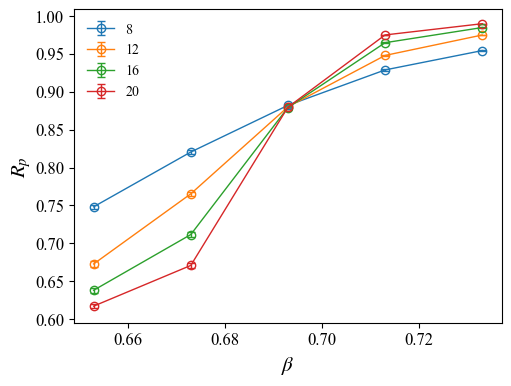

In [16]:
import matplotlib.pyplot as pt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FixedLocator, FixedFormatter, NullFormatter
import scipy

cs = ['m', 'b', 'c', 'g', 'y', 'r', 'orange', 'gray', 'k']
ms = ['o', '^', 'v', 's', 'p', '*', 'x', '<','D']
cs = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 
      'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'gold', 'darkblue']
ms = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'X', 'h', '+']

pt.rc('font', family='Times New Roman', weight=400)  # 设置英文字体为 Times New Roman
pt.rc('mathtext', fontset='stix')  # 设置数学公式字体为 STIX（与 Times 风格一致）
pt.rc('text', usetex=False)  # 如果需要，可以设置为 usetex=True 使用 LaTeX 渲染
# 设置论文中双栏宽度（假设双栏宽度为 7 英寸，具体根据期刊要求调整）
total_width = 5  # 整个组合图的宽度，单位为英寸
aspect_ratio = 4 / 3  # 子图的宽高比为 4:3
# 子图布局：1 行 2 列
ncols = 1
nrows = 1
# 计算单个子图的宽度和高度
subplot_width = total_width / ncols
subplot_height = subplot_width / aspect_ratio
# 设置整个图形的大小
figsize = (total_width, subplot_height * nrows)
# 创建子图
fig, ax = pt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,constrained_layout=True)
text_size=15
tick_size=13

# sigma = ['1.750']
# sigma = ['1.01000']
H = ['0.00000']
# L = ['64','128','256','512','1024','2048','4096','8192','16384']
L = ['8','12','16','20']

# ax.set_xscale('log')
# ax.set_yscale('log')

i = -1
for l in L:
    for h in H:
        i += 1
        data_path = '../data/cmp/cmp_L_' + l + '_h_' + h + '.dat'
        #________________________________________________
        x_list = read_column_by_name(data_path, 'beta')
        Q_list = read_column_by_name(data_path, '<Qm>')
        Qerr_list = read_column_by_name(data_path, '<Qm>_err')
        
        #________________________________________________

        #________________________________________________
        ax.errorbar(
        x_list, Q_list, Qerr_list,
        fmt='o', 
        linestyle='-', 
        markersize=6, color=cs[i],
        ecolor=cs[i], elinewidth=1, capsize=3, capthick=1,
            markerfacecolor='none',
        label=str(l), zorder=2,
        linewidth=1   # 这里设置线宽为1，数值越小线越细
        )

ax.yaxis.label.set_verticalalignment('center')   # 垂直居中
ax.set_ylabel(r'$R_p$',fontsize=text_size,rotation=90,labelpad=10)
ax.set_xlabel(r'$\beta$',fontsize=text_size)

ax.legend(fontsize=10,frameon=False)
# ax.set_xlim(4, 20)
# ax.set_xticks(ticks=[4,6, 10,20]) 
# ax.set_xticklabels(labels=['4','6', '10', '20'])

# x = np.linspace(4, 1e5,100000)
# ax.plot(x, (-92.6555593 + 83.5091655 * x**(0.27857617)) * x**(-0.125), color=cs[0], linewidth=1)
# ax.plot(x, np.log(x) * 19.6817432 + 7.17009897, color=cs[1], linewidth=1)
# ax.plot(x, [46.29991]*len(x), color=cs[2], linewidth=1)

# ax.axvline(x=1.07)

ax.tick_params(axis='both', which='major', labelsize=12)
############################################################################################################
fig_name = 'fig'
pt.savefig(fig_name + '.pdf', bbox_inches='tight')
pt.savefig(fig_name + '.png', dpi = 500, bbox_inches='tight')
pt.show()